In [ ]:
"""
Author: Thomas Theisen -> Data Scientist @ Striveworks
"""

In [ ]:
from IPython.display import Image

In [14]:
# !python3 -m pip install dataclasses
# !python3 -m pip install numpy
# !python3 -m pip install scipy
# !python3 -m pip install pandoc

    100% |████████████████████████████████| 491kB 2.7MB/s eta 0:00:01
    100% |████████████████████████████████| 51kB 3.7MB/s eta 0:00:01
  Running setup.py bdist_wheel for pandoc ... done
  Stored in directory: /home/ttheisen/.cache/pip/wheels/d1/e8/71/bc3242b3e8f119c62eebdb0dee519fd40ac293e4835839db7c
Successfully built pandoc


**Tracking Objects as Points:**

- Paper Link: https://arxiv.org/abs/2004.01177

- Repo Link: https://github.com/xingyizhou/CenterTrack

**Tracking-By-Detection**

 - This framework relies on an accurate detection step followed by linking these detections with existing tracks. Many rely on slow and complex association strategies to form these links. Many of these tracking-after-detection strategies use Kalman Filters to model track position and velocities and use the Hungarian Maximum Matching algorithm to associate tracks to detections.

Simple Online Real-Time Tracking (SORT)

    - Find objects within current frame
    - Associate new detections to existing tracks via intersection over union (IOU)
    - Link: https://arxiv.org/abs/1602.00763
    
DeepSORT

    - Compute appearance features for every object detected (https://kaiyangzhou.github.io/deep-person-reid/)
    - Use these features to augment the IOU based association cost matrix
    - Link: https://arxiv.org/pdf/1703.07402.pdf
    
**Joint Detection and Tracking**

- Convert existing detectors in trackers. 

- Single-shot, anchor based methods have been known to fail

- The introduction of FairMOT (https://arxiv.org/pdf/2004.01888.pdf) details why trackers based on anchors using re-id features actually degard tracking accuracy.
   - anchor based re-id fatures are not suitable for learning and produce a large number of track id switches
   - model is biased to estimate accurate object proposals rather than quality re-id features

**Kalman Filter**

- If all noise is considered gaussian, the kalman filter minimizes the mean square error of the estimated parameters.

- State Equation

   $ x(t + 1) = F(t)x(t) + G(t)u(t) + v(t) $
   
   Where,
   
     - $ F(t) $ is the state transition matrix and $ x(t) $ is the $ n_{x} $ dimensional state vector.
     
     - $ G(t) $ is the control transition matrix and $ u(k) $ is the $ n_{u} $ dimensional input vector.
     
     - $ v(t) $ is the unknown process noise. 
   
   
- Measurement Equation
    
   $ z(t) = Hx(t) + w(t) $
   

In [19]:
import numpy as np

position_observations = np.array([4000, 4260, 4550, 4860, 5110])

velocity_observations = np.array([280, 282, 285, 286, 290])
z = np.c_[position_observations, velocity_observations]

""" Conditions """
acceleration = 2
v = 280
t = 1

""" Process Estimation Errors """
estimated_error_position = 20
estimated_error_velocity = 5

""" Observation Uncertainty """
error_position_observation = 25
error_velocity_observation = 6

def prediction2d(x, v, t, a):
    """ State transtion matrix """
    A = np.array([[1, t],
                  [0, 1]])
    """ Current state """
    X = np.array([[x],
                  [v]])
    """ Control transtion matrix """
    B = np.array([[0.5 * t ** 2],
                  [t]])
    x_prime = A.dot(X) + B.dot(a)
    return x_prime

def covariance2d(sigma1, sigma2):
    cov1_2 = sigma1 * sigma2
    cov2_1 = sigma2 * sigma1
    cov_matrix = np.array([[sigma1 ** 2, cov1_2],
                           [cov2_1, sigma2 ** 2]])
    return np.diag(np.diag(cov_matrix))

""" Initial Estimation Covariance Matrix """
P = covariance2d(estimated_error_position, estimated_error_velocity)
A = np.array([[1, t],
              [0, 1]])

""" Initial State Matrix """
X = np.array([[z[0][0]], [v]])
n = len(z[0])

for data in z[1:]:
    
    """ Predict new (position, velocity) state """
    X = prediction2d(X[0][0], X[1][0], t, acceleration)
    
    """ Update the covariance matrix """
    P = np.diag(np.diag(A.dot(P).dot(A.T)))

    """ Calculate the measurement noise"""
    R = covariance2d(error_position_observation, error_velocity_observation)
    
    """ Calculating system uncertainity (covariance matrix (P) projected to measurement space)"""
    H = np.identity(n)
    S = H.dot(P).dot(H.T) + R
    
    """ Calculating the kalman gain """
    K = P.dot(H).dot(np.linalg.inv(S))

    """ Reshape the new data into the measurement space. """
    Y = H.dot(data).reshape(n, -1)

    """ Update the state matrix """
    X = X + K.dot(Y - H.dot(X))

    """ Update process covariance matrix """
    P = (np.identity(len(K)) - K.dot(H)).dot(P)

print("Kalman Filter State Matrix:\n", X)

Kalman Filter State Matrix:
 [[5127.05898493]
 [ 288.55147059]]


**Hungarian Maximum Matching Algorithm**

- Used to find maximum-weight matching in bipartite graphs aka the assignment problem.

- Complexity: $ O(V^{3}) $

- In our case, the bipartite graph is represented as an adjacency matrix.

Example Matrix:

$ \begin{vmatrix}
108 & 125 & 150 \\
150 & 135 & 175 \\
122 & 148 & 250 \\
\end{vmatrix} $

**Step 1**

- Subtract the smallest entry in each row from all the other entries in the row. This will make the smallest entry in the row now equal to 0.

$ \begin{vmatrix}
0 & 17 & 42 \\
15 & 0 & 40 \\
0 & 26 & 128 \\
\end{vmatrix} $

**Step 2**

- Subtract the smallest entry in each column from all the other entries in the column. This will make the smallest entry in the column now equal to 0.

$ \begin{vmatrix}
0 & 17 & 2 \\
15 & 0 & 0 \\
0 & 26 & 88 \\
\end{vmatrix} $

**Step 3**

- Draw lines through the row and columns that have the 0 entries such that the fewest lines possible are drawn.

**Step 4**

- If there are n lines drawn, an optimal assignment of zeros is possible and the algorithm is finished. If the number of lines is less than n, then the optimal number of zeroes is not yet reached. Go to the next step.

**Step 5**

- Find the smallest entry not covered by any line. Subtract this entry from each row that isn’t crossed out, and then add it to each column that is crossed out. Then, go back to Step 3.

$ \begin{vmatrix}
-2 & 15 & 0 \\
15 & 0 & 0 \\
-2 & 24 & 86 \\
\end{vmatrix} $

$ \begin{vmatrix}
0 & 15 & 0 \\
17 & 0 & 0 \\
0 & 24 & 86 \\
\end{vmatrix} $


In [11]:
import numpy as np
from scipy.optimize import linear_sum_assignment
from dataclasses import dataclass
from typing import Tuple

@dataclass
class Track:
    position: np.ndarray
        
@dataclass
class Detection:
    bounding_box: np.ndarray
        
def iou(bbs: Tuple[np.ndarray, np.ndarray]) -> float:
    bb1, bb2 = bbs
    xx1 = np.maximum(bb1[1], bb2[1])
    yy1 = np.maximum(bb1[0], bb2[0])
    xx2 = np.minimum(bb1[3], bb2[3])
    yy2 = np.minimum(bb1[2], bb2[2])
    w = np.maximum(0.0, xx2 - xx1)
    h = np.maximum(0.0, yy2 - yy1)
    wh = w * h
    o = wh / (
        (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
        + (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])
        - wh
    )
    return o

tracks = [
    Track(position=np.array([10.0, 10.0, 20.0, 20.0])),
    Track(position=np.array([50.0, 50.0, 70.0, 70.0]))
]

detections = [
    Detection(bounding_box=np.array([52.0, 55.0, 68.0, 73.0])),
    Detection(bounding_box=np.array([35.0, 50.0, 62.0, 65.0]))
]

cost_matrix = np.zeros((len(tracks), len(detections)))
for i, t in enumerate(tracks):
    for j, d in enumerate(detections):
        cost_matrix[i, j] = iou(bbs=(t.position, d.bounding_box))

print(cost_matrix)

row_ind, col_ind = linear_sum_assignment(-cost_matrix)
print(row_ind, col_ind)

[[0.         0.        ]
 [0.53571429 0.288     ]]
[0 1] [1 0]


**CenterNet**

- Represents objects by a single point at the bounding box center

- Other properties (object size, dimension, pose, etc) are regressed directly from image features at the center location

- Centernet takes a single image $ I \in R^{W*H*3} $ as input and produces a set of detections $ \{(pi, si)\} $ for each class $ c \in \{0, ..., C - 1\} $. 

- CenterNet identifies each object by a center point $ p \in R^2 $ and regresses a height and width $ s \in R^2 $.

- More specifically, a low-resolution heatmap $ \hat{Y} \in [0,1]^{W/R * H/R * C} $ and size map $ \hat{S} \in [0,1]^{W/R * H/R * 2} $ are produced, where $ R = 4 $ and $ C $ is the number of object classes.

- $ Y_{xyc} = 1 $ corresponds to a detected keypoint.

- Peaks $ \hat{p} $ are localized in $ 3 x 3 $ neighborhoods with confidence $ \hat{w} $ and object size $ \hat{s} $.

- Possible backbones: Stacked hourglass, ResNet, and DLA

**CenterNet Training**

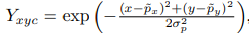

In [14]:
Image("static/pngs/centernet_gaussian.PNG")

$ L_{k} $ is pixel-wise logistic regression with focal loss, where $ \alpha = 2 $ and $ \beta = 4 $ and $ N $ is the number of keypoints in the image

$ L_{size} $ is an $ L1 $ loss for regressing object size

$ L_{off} $ is added to recover error caused by addition of the output stride $ R $

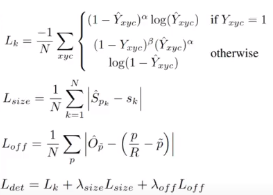

In [15]:
Image("static/pngs/centernet_losses.PNG")

**CenterTrack**

- Object tracking is the task of taking an initial set of object detections, creating a unique id for each, and then tracking each of those objects as they move in a video sequence.

- Centertrack builds on the CenterNet detector and is classified as a simultaneous detection and tracking method. Approach tracking from a local prespective. An object that is occluded or left the scene is assigned a new identity. That is, no effort is made to re-identify objects across temporal gaps.

- Each object is represented by a single point at the center of the bounding box.

- Acheives state-of-the-art of the MOTA on MOT17 and Kitti benchmark challenges.

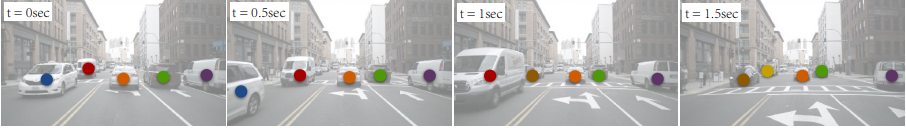

In [9]:
Image("static/pngs/centertrack.PNG")

At time $ t $, three items are used to propogate existing tracks or create new tracks: 

   - Current Frame: $ I^{(t)} \in R^{(W*H*3)} $
    
   - Previous Frame: $ I^{(t - 1)} \in R^{(W*H*3)} $
   
   - Tracked Objects from Previous Frame: $ T^{(t - 1)} = \{b_{0}^{(t-1)}, b_{1}^{(t-1)}, ... \} $
       - These are passed in a class agnostic heatmap $ H^{(t - 1)} \in R^{(W/R*H/R*1)} $
       - Only prior detections with confidence exceeding $ \tau $ are passed
   
Each object $ b $ takes the form  $ (p, s, w, id) $ where $ p $ is the object center, $ s $ is the object size, $ w $ is the detection confidence, and $ id $ is the unique id.

**Objective** -> detect and track objects $ T^{(t)} = {b_{0}^{(t-1)}, b_{1}^{(t-1)}, ... } $ for the current frame $ t $.

**Challenges** -> 

   - Finding all objects in every frame, including occluded ones
   
   - Associating objects through time

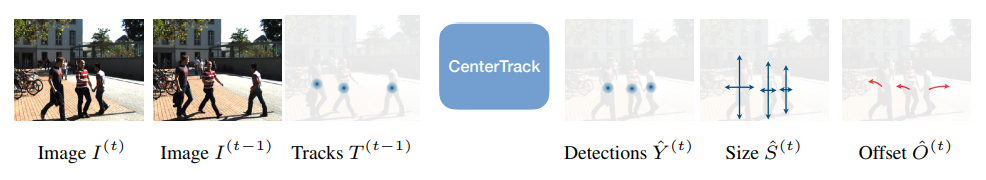

In [16]:
Image("static/pngs/centertrack_steps.PNG")

**Tracking-Conditioned Detection**

- Provide the previous frame to allow the network to potentially recover occluded objects at time $ t $ from visual evidence at time $ t - 1 $.

- Pass all prior detections in a single-channel heatmap $ H^{(t-1)} = R({p_{0}^{(t-1)}, p_{1}^{(t-1)} ...}) $

**Association Through Offsets**

- To associate detections through time, a 2D displacement $ \hat{D}^{(t)} \in R^{(W/R * H/R * 2)} $ is predicted.

- For each detected object at $ \hat{p} $ the displacement $ \hat{d} $ captures the difference $ \hat{p}^{(t)} - \hat{p}^{(t - 1)} $.

- A greedy matching algorithm is used to associate across time. For each detection at position $ \hat{p}^{(t)} $, associate it with the closest prior detection $ \hat{p}^{(t-1)} $ in descending order of $ \hat{w} $.

- If no $ \hat{p}^{(t-1)} $ within radius $ k $ of $ \hat{p}^{(t)} $ exists, create a new track. Where $ k $ is the geometric mean of the width and height of the predicted bounding box.

**Training**

- Architecture changes from CenterNet -> four additional input channels and two additional output channels.

- Allows for copying of base CenterNet weights into CenterTrack model, and the random initialization of remaining/new weights.

- Same training loss, with the addition of the offset/displacement loss function

- Claim: Can be trained on static images with "hallucinated" motion

**Augmentations in Training**

- At inference time, the tracklet heatmap can contain missing tracklets, wrongly localized objects, and false positives.

- Simulate 3 types of error during training
    - Locally jitter each track $ p^{(t-1)} $ from the prior frame by adding gaussian noise
    - Randomly add false positives near ground-truth locations, i.e. spurious peaks
    - Randomly removing detections to simulate false negatives
   
- Randomly sample frames around time $ t $

**Results on MOT17**

- Multiple Object Tracking Accuracy (MOTA)
    - $ 1 - (\sum (FP + FN + IDS) / (\sum GT))$
    
- python library for tracking metrics: https://github.com/cheind/py-motmetrics

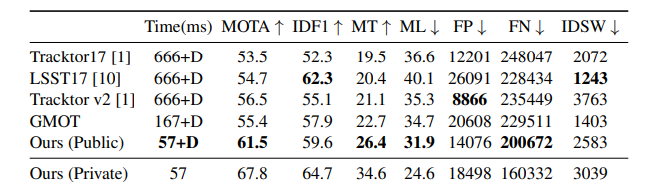

In [17]:
Image("static/pngs/centertrack_results.PNG")